## **Sentiment analysis using TF-IDF embeddings and LSTM.**




In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import zipfile

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import keras

from keras.models import Model
from keras.layers import Dense, Activation, concatenate, Embedding, Input

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

Loading the Dataset.

In [72]:
df = pd.read_json('/content/Amazon_Instant_Video_5.json', lines = True)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A11N155CW1UV02,B000H00VBQ,AdrianaM,"[0, 0]",I had big expectations because I love English ...,2,A little bit boring for me,1399075200,"05 3, 2014"
1,A3BC8O2KCL29V2,B000H00VBQ,Carol T,"[0, 0]",I highly recommend this series. It is a must f...,5,Excellent Grown Up TV,1346630400,"09 3, 2012"
2,A60D5HQFOTSOM,B000H00VBQ,"Daniel Cooper ""dancoopermedia""","[0, 1]",This one is a real snoozer. Don't believe anyt...,1,Way too boring for me,1381881600,"10 16, 2013"
3,A1RJPIGRSNX4PW,B000H00VBQ,"J. Kaplan ""JJ""","[0, 0]",Mysteries are interesting. The tension betwee...,4,Robson Green is mesmerizing,1383091200,"10 30, 2013"
4,A16XRPF40679KG,B000H00VBQ,Michael Dobey,"[1, 1]","This show always is excellent, as far as briti...",5,Robson green and great writing,1234310400,"02 11, 2009"


In [73]:
len(df)

37126

In [74]:
df = df.sample(n=10000)

In [75]:
len(df)

10000

In [76]:
df["textlength"] = df["reviewText"].apply(len)

In [77]:
df.describe()

,overall,unixReviewTime,textlength
count,10000.00000,1.000000e+04,10000.000000
mean,4.20570,1.376630e+09,513.664200
std,1.12415,3.042675e+07,822.167195
min,1.00000,1.159661e+09,9.000000
25%,4.00000,1.367712e+09,145.000000
50%,5.00000,1.384646e+09,234.500000
75%,5.00000,1.394064e+09,488.000000
max,5.00000,1.406074e+09,14804.000000


In [78]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,textlength
26899,ANGNKTK2J7JFF,B00DENPU6E,Madeline,"[1, 1]",Much of the comedy in this movie made me borde...,4,"Low Budget and Sometimes Awkward, But Still Qu...",1375488000,"08 3, 2013",1292
10549,ASXB5L2T8LX62,B005K1MJ4E,Edris Cooper,"[0, 0]",Just the thing to get me laughing after a hard...,5,Just flat fun,1401667200,"06 2, 2014",148
21832,A3I5WEFXRDWDO3,B00BFQ1OFI,"Juan ""Prince Moloch""","[0, 0]",Although it seemed to be losing some steam thi...,4,Great Police Drama,1394409600,"03 10, 2014",160
27808,A2B4K9929TBP30,B00DVFR8QA,"Warren Johnson ""Warren the Camera Guy""","[0, 4]","I know, I know..... I only managed to watch 5 ...",2,"Please, someone write a good show",1378857600,"09 11, 2013",1832
24223,A2MH054G8CRIDZ,B00CDBR1P6,Alliee,"[0, 0]",The show is okay. The plot has a serious theme...,3,"Some good, some???????",1367625600,"05 4, 2013",438


In [79]:
df.tail()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,textlength
28424,A3PAUB3M715CJC,B00EJLRV6M,the Commish!!!,"[0, 0]",my wife loved it !!! wishes more of the shows ...,5,wife,1377216000,"08 23, 2013",97
37002,A19E0OCY1W02LV,B00L86ZKAK,NormaJean James,"[1, 2]",This 2nd season is even better than the 1st.,5,Five Stars,1405382400,"07 15, 2014",44
8119,A3D2HAESTLGGDW,B004KPX56C,Jennifer DeBoin,"[0, 0]",Has some educational aspects which are a must ...,5,Kids Love this show!,1401321600,"05 29, 2014",115
27060,A1C9N96N2M5D13,B00DKSAIJM,"marriedutopianstriver ""Seeker Of Heaven On Earth""","[1, 1]","""Devious Maids"" Season 1 pilot episode feature...",5,Complicated Situations,1373068800,"07 6, 2013",2230
24857,A13XLA2DAZHETS,B00CDBTQCW,"Ziggy ""Love2read""","[0, 0]","Interesting seeing the 'inside' of politics, a...",2,Could have been great,1389139200,"01 8, 2014",248


In [80]:
df['reviewText']

26899    Much of the comedy in this movie made me borde...
10549    Just the thing to get me laughing after a hard...
21832    Although it seemed to be losing some steam thi...
27808    I know, I know..... I only managed to watch 5 ...
24223    The show is okay. The plot has a serious theme...
                               ...                        
28424    my wife loved it !!! wishes more of the shows ...
37002         This 2nd season is even better than the 1st.
8119     Has some educational aspects which are a must ...
27060    "Devious Maids" Season 1 pilot episode feature...
24857    Interesting seeing the 'inside' of politics, a...
Name: reviewText, Length: 10000, dtype: object

In [81]:
df = df[['reviewText', 'overall']]
df.head()

,reviewText,overall
26899,Much of the comedy in this movie made me borde...,4
10549,Just the thing to get me laughing after a hard...,5
21832,Although it seemed to be losing some steam thi...,4
27808,"I know, I know..... I only managed to watch 5 ...",2
24223,The show is okay. The plot has a serious theme...,3


In [82]:
df['overall'] = [1 if overall > 2 else 0 
                            for overall in df['overall'].values]
df.head()

,reviewText,overall
26899,Much of the comedy in this movie made me borde...,1
10549,Just the thing to get me laughing after a hard...,1
21832,Although it seemed to be losing some steam thi...,1
27808,"I know, I know..... I only managed to watch 5 ...",0
24223,The show is okay. The plot has a serious theme...,1


In [83]:
df.shape

(10000, 2)

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 26899 to 24857
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  10000 non-null  object
 1   overall     10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 234.4+ KB


In [85]:
df['overall'].value_counts()

1    9029
0     971
Name: overall, dtype: int64

Spliting the data into train and test sets:

In [86]:
X = df['reviewText']
y = df['overall']

X_train_sentences, X_test_sentences, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

**Tokenizing the words.**

In [124]:
vocab_size = 5000
embedding_dim = 16
max_len = 100
trunction_type='post'
padding_type='post'
oov_token = "<OOV>"

In [137]:
tfidf = TfidfVectorizer(max_features = 100) 
tfidf.fit(X_train_sentences)
X_tfidf_features = tfidf.transform(X_train_sentences).toarray()
Y_tfidf_features = tfidf.transform(X_test_sentences).toarray()
tfidf_vector_X_train = X_tfidf_features[:, :, None] #//shape - (3,6,1) 
tfidf_vector_X_test = Y_tfidf_features[:, :, None] #//shape - (3,6,1)

`texts_to_sequences` convert the words into sequences so that a complete sequence of numbers can represent every sentence. 

In [126]:
X_train = tokenize.texts_to_sequences(X_train_sentences)
X_test = pad_sequences(X_train, maxlen=max_len)

Using `pad_sequences`function to make it uniform.

In [127]:
X_train_pad = pad_sequences(X_train,maxlen=max_len, padding=padding_type, 
                            truncating=trunction_type)

X_test_pad = pad_sequences(X_test,maxlen=max_len, padding=padding_type, 
                           truncating=trunction_type)

### **TF-IDF Embedding**


Finally we create the embedding layer:


In [128]:
tfidf_embed=np.asarray(tfidf_features[0])

In [129]:
embedding_layer = Embedding(vocab_size,
                            max_len,
                            weights=[tfidf_embed],
                            input_length=max_len,
                            trainable=False)

In [130]:
embedding_layer

In [131]:
maxlen=100

In [132]:
vocab_size = len(tokenize.word_index) + 1
embedding_size = 16

input_tfidf = Input(shape=(300,))
input_text = Input(shape=(maxlen,))

mean_embedding = keras.layers.Lambda(lambda x: keras.backend.mean(x, axis=1))(embedding)
concatenated = concatenate([input_tfidf, mean_embedding])
embedding = Embedding(vocab_size, embedding_size, input_length=maxlen)(concatenated)

In [133]:
embedding_layer = Embedding(num_words,
                            max_len,
                            weights=[concatenated],
                            input_length=max_len,
                            trainable=False)

### **Build the model**

In [134]:
embedding_dim = 16

In [141]:
model = Sequential([
    Bidirectional(LSTM(embedding_dim, input_shape=tfidf_vector_X_train.shape[1:],return_sequences=True)), 
    Bidirectional(LSTM(embedding_dim)),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [147]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_36 (Bidirectio (None, 100, 32)           2304      
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 32)                6272      
_________________________________________________________________
dense_38 (Dense)             (None, 6)                 198       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 7         
Total params: 8,781
Trainable params: 8,781
Non-trainable params: 0
_________________________________________________________________


In [142]:
callbacks = EarlyStopping(monitor = 'val_accuracy', 
                          mode = 'max', 
                          patience = 10,
                          verbose = 1)

Train the model for 5 epochs.

In [143]:
history = model.fit(tfidf_vector_X_train, y_train,
                    batch_size=32,
                    epochs=5,
                    validation_data=(tfidf_vector_X_test, y_test),
                    verbose=1,
                    callbacks=callbacks
                    )

Epoch 1/5
250/250 [==============================] - 28s 86ms/step - loss: 0.4108 - accuracy: 0.9004 - val_loss: 0.3110 - val_accuracy: 0.9065
Epoch 2/5
250/250 [==============================] - 19s 75ms/step - loss: 0.3208 - accuracy: 0.9025 - val_loss: 0.3120 - val_accuracy: 0.9065
Epoch 3/5
250/250 [==============================] - 19s 75ms/step - loss: 0.3138 - accuracy: 0.9056 - val_loss: 0.3143 - val_accuracy: 0.9065
Epoch 4/5
250/250 [==============================] - 19s 75ms/step - loss: 0.3241 - accuracy: 0.9005 - val_loss: 0.3107 - val_accuracy: 0.9065
Epoch 5/5
250/250 [==============================] - 19s 75ms/step - loss: 0.3246 - accuracy: 0.9008 - val_loss: 0.3107 - val_accuracy: 0.9065


Predictions on a test set:

In [144]:
loss, accuracy = model.evaluate(tfidf_vector_X_test,y_test)
print('Test accuracy :', accuracy)

63/63 [==============================] - 1s 22ms/step - loss: 0.3107 - accuracy: 0.9065
Test accuracy : 0.906499981880188


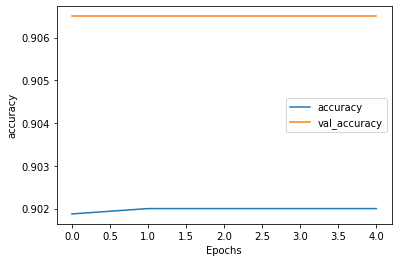

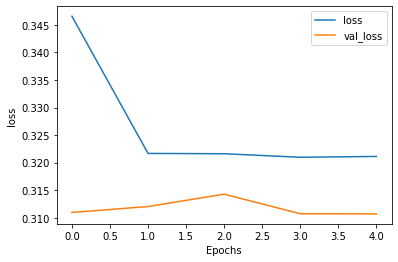

In [145]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [146]:
model.save("Tf-Idf_model")

INFO:tensorflow:Assets written to: Tf-Idf_model/assets


INFO:tensorflow:Assets written to: Tf-Idf_model/assets
